# Data Understanding

Dataset yang digunakan dalam proyek ini adalah dataset "News Articles" yang diperoleh dari Kaggle. Anda dapat mengunduh dataset tersebut dari tautan berikut: [News Articles Dataset](https://www.kaggle.com/datasets/bavalpreet26/newsarticle/data).

## Variable in News Articles Dataset :

1. **Article_Id**: Pengenal unik untuk setiap artikel dalam dataset.
2. **Title**: Judul atau tajuk utama artikel berita, yang memberikan ringkasan atau deskripsi singkat tentang isinya.
3. **Author**: Nama penulis atau kontributor yang menulis artikel.
4. **Date**: Tanggal dan waktu ketika artikel diterbitkan atau terakhir diperbarui.
5. **Content**: Bagian utama artikel, yang berisi informasi, berita, atau analisis terperinci.
6. **URL**: URL web atau tautan untuk mengakses artikel lengkap secara online, biasanya dihosting di situs web publikasi.

# Prepare Dataset

## Download Dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhamadalan","key":"3234178b0250039a2aa69d80d9d3cb4c"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d bavalpreet26/newsarticle

  0% 0.00/2.81M [00:00<?, ?B/s]
100% 2.81M/2.81M [00:00<00:00, 45.7MB/s]


In [4]:
!unzip '/content/newsarticle.zip'

Archive:  /content/newsarticle.zip
  inflating: news_articles.csv       


## Import Library

In [5]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Load Dataset

In [6]:
articles = pd.read_csv('/content/news_articles.csv')
data = articles.copy()

In [7]:
data.head()

,Article_Id,Title,Author,Date,Content,URL
0,0,14 dead after bus falls into canal in Telangan...,Devyani Sultania,"August 22, 2016 12:34 IST",At least 14 people died and 17 others were inj...,http://www.ibtimes.co.in/14-dead-after-bus-fal...
1,1,Pratibha Tiwari molested on busy road Saath ...,Suparno Sarkar,"August 22, 2016 19:47 IST",TV actress Pratibha Tiwari who is best known ...,NaN
2,2,US South Korea begin joint military drill ami...,Namrata Tripathi,"August 22, 2016 18:10 IST",The United States and South Korea began a join...,http://www.ibtimes.co.in/us-south-korea-begin-...
3,3,Illegal construction in Bengaluru Will my hou...,S V Krishnamachari,"August 22, 2016 17:39 IST",The relentless drive by Bengaluru s Bangalore...,http://www.ibtimes.co.in/illegal-construction-...
4,4,Punjab Gau Rakshak Dal chief held for assaulti...,Pranshu Rathee,"August 22, 2016 17:34 IST",Punjab Gau Raksha Dal chief Satish Kumar and h...,http://www.ibtimes.co.in/punjab-gau-rakshak-da...


# Data Wrangling

## Data Assessing

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4831 entries, 0 to 4830
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Article_Id  4831 non-null   int64 
 1   Title       4831 non-null   object
 2   Author      4825 non-null   object
 3   Date        4826 non-null   object
 4   Content     4831 non-null   object
 5   URL         3389 non-null   object
dtypes: int64(1), object(5)
memory usage: 226.6+ KB


## Data Cleaning

In [9]:
data.isna().sum()

Article_Id       0
Title            0
Author           6
Date             5
Content          0
URL           1442
dtype: int64

In [10]:
data.drop(columns=['URL', 'Date'], axis=1, inplace=True)

In [11]:
data.dropna(inplace=True)

In [12]:
data.isna().sum()

Article_Id    0
Title         0
Author        0
Content       0
dtype: int64

In [13]:
data.duplicated().sum()

0

# Data Prepocessing

In [14]:
# Convert column names to lowercase for consistency and ease of access
data.columns = data.columns.str.lower()
articles.columns = articles.columns.str.lower()

In [15]:
# Define function to clean author column
def clean_author_names(authors):
    cleaned_authors = []
    for author in authors:
        # Remove additional information using regex pattern
        author = re.sub(r'\b(?:is a.*in female lead roles?.*|the movie has.*in female lead roles?.*|.*is a.*|.*in female lead roles?.*)\b', '', author)

        # Standardize format: Convert to lowercase and remove leading/trailing spaces
        author = author.lower().strip()

        # Handle variations and abbreviations
        if author == 'ians':
            author = 'indo-asian news service'

        cleaned_authors.append(author)

    return cleaned_authors

# Apply cleaning function to the 'author' column
data['author'] = clean_author_names(data['author'])

In [16]:
# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # Join tokens back into a single string
    clean_text = ' '.join(lemmatized_tokens)
    return clean_text

# Clean the column
data['content'] = data['content'].apply(clean_text)
data['title'] = data['title'].apply(clean_text)

# EDA

In [17]:
pd.DataFrame(data['author'].value_counts())

,author
rohit kvn,462
besta shankar,340
prakash upadhyaya,302
mugdha variyar,261
anu james,254
...,...
monika shukla,1
vishnuprasad pillai,1
"vasudevan sridharan ibtimes uk , jayalakshmi k ibtimes uk",1
"neha singh , udayan nag",1


In [18]:
pd.DataFrame(data['author'].value_counts().head(15))

,author
rohit kvn,462
besta shankar,340
prakash upadhyaya,302
mugdha variyar,261
anu james,254
neha singh,239
shekhar h hooli,228
prarthna sarkar,189
s v krishnamachari,164
ashim sunam,150


In [19]:
data.shape

(4825, 4)

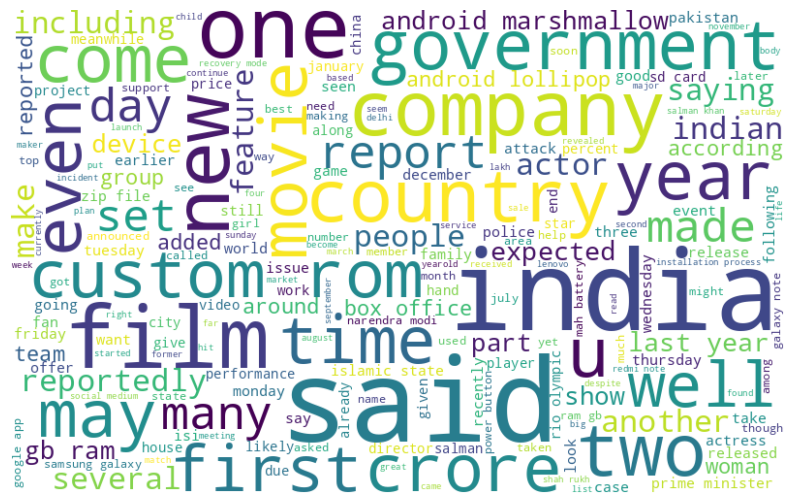

In [20]:
# Define a function to generate and display a word cloud from a given string of words
def wordCloud(words):

    # Generate the word cloud with specified parameters
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')

# Concatenate all words from the 'content' column into a single string
all_words = ' '.join([text for text in data['content']])
wordCloud(all_words)

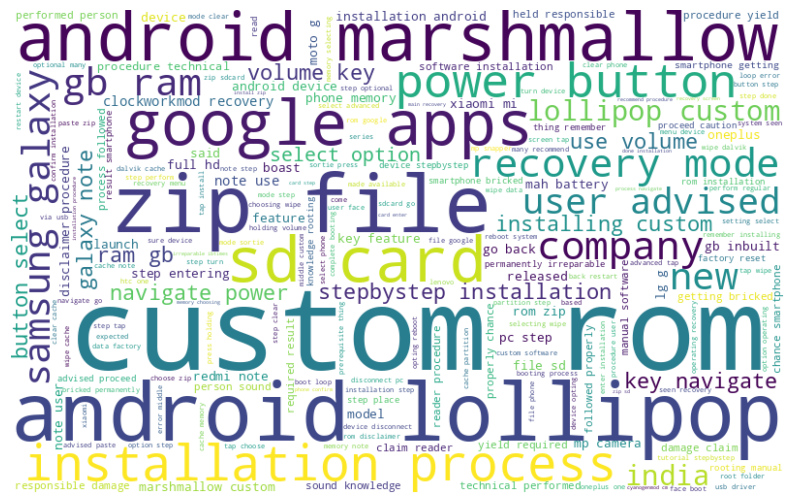

In [21]:
# Filter the DataFrame to select rows where the author is "Rohit KVN"
rohit_kvn_content = ' '.join(data[data['author'] == 'rohit kvn']['content'])

# Generate and display the word cloud for Rohit KVN's content
wordCloud(rohit_kvn_content)

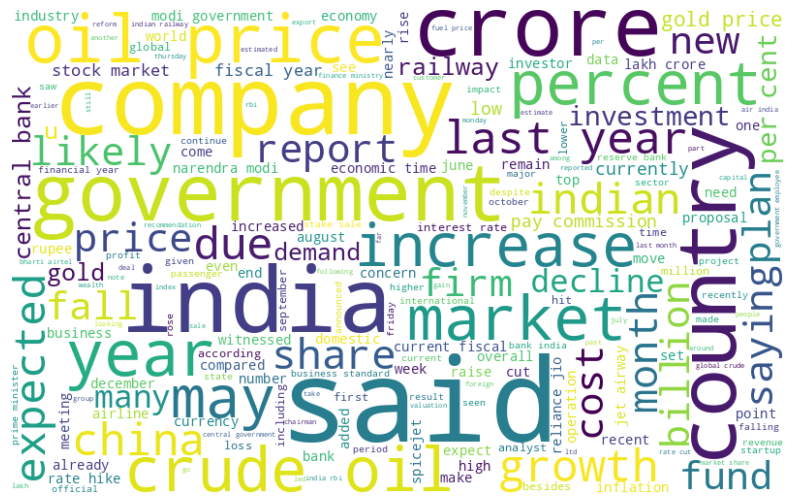

In [22]:
# Filter the DataFrame to select rows where the author is "Rohit KVN"
rohit_kvn_content = ' '.join(data[data['author'] == 'besta shankar']['content'])

# Generate and display the word cloud for Rohit KVN's content
wordCloud(rohit_kvn_content)

In [23]:
data['title'].unique()

array(['dead bus fall canal telangana khammam district andhra cm promise r lakh compensation',
       'pratibha tiwari molested busy road saath nibhana saathiya actress drag accused police station',
       'u south korea begin joint military drill amid nuclear threat north korea',
       ...,
       'samsung galaxy active water resistant variant leak samsung website release date',
       'google roll android lollipop ota improvement new feature',
       'apple decorates homepage beautiful image taken using iphones trick beat samsung'],
      dtype=object)

In [24]:
from collections import Counter

# Function to extract top 5 most common words from content
def top_words(content):
    words = word_tokenize(content.lower())
    word_count = Counter(words)
    top_5_words = [word for word, count in word_count.most_common(5)]
    return top_5_words

# Group data by author and apply the function to extract top words
top_words_data = data.groupby('author')['content'].apply(lambda x: top_words(' '.join(x))).reset_index()

# Rename the columns
top_words_data.columns = ['author', 'top_5_words']

top_words_data.sample(5)

,author,top_5_words
70,sangeetha seshagiri,"[film, crore, box, office, year]"
13,asmita sarkar,"[said, also, people, india, attack]"
3,amit malaviya,"[minister, swaraj, party, modi, india]"
29,ibtimes staff reporter,"[said, india, minister, also, government]"
44,neha singh,"[said, police, india, government, minister]"


# Content-based Filtering

In [29]:
# Concatenate the 'author', 'title', and 'content' columns to create a single text string representing each news article
news = data['author'] + ' ' + data['title'] + ' ' + data['content']

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(news)

# Compute similarity scores
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to recommend similar articles
def content_based_recommendation(text, top_n=5):
    # Preprocess the query and convert it into a feature vector
    query_vector = tfidf_vectorizer.transform([text])

    # Calculate cosine similarity between the query vector and all articles
    sim_scores = cosine_similarity(query_vector, tfidf_matrix)

    # Rank articles based on similarity scores
    ranked_indices = sim_scores.argsort()[0][::-1]

    # Return top-N recommended articles and their similarity scores
    top_indices = ranked_indices[1:top_n+1]  # Exclude the query itself
    recommendations = data.iloc[top_indices]
    similarity_scores = sim_scores[0][top_indices]

    return recommendations, similarity_scores

# Getting Recommendation

In [32]:
# Input free text
free_text = 'horror movie recommendations'

# Generate content-based recommendations for the given free text query
recommendations, similarity_scores = content_based_recommendation(free_text)

In [35]:
recommendations_df = pd.DataFrame(recommendations)
recommendations_df

,article_id,title,author,content
664,664,fireman box office controversy producer milan ...,nicy v.p,malayalam cinema industry making headline new ...
2147,2147,malayalam cinema top movie year,nicy v.p,malayalam cinema given many reason movie buff ...
2176,2176,tamil film producer decide release big movie f...,nicy v.p,tamil film producer decision release big movie...
335,335,pasanga haiku movie review live audience response,prakash upadhyaya,produced actor suriya pasanga also known haiku...
2170,2170,kerala box office collection mammootty dulquer...,nicy v.p,father son duo malayalam cinema mammootty dulq...


In [36]:
similarity_scores_df = pd.DataFrame({'article_id': recommendations_df['article_id'], 'similarity_score': similarity_scores})
similarity_scores_df

,article_id,similarity_score
664,664,0.148865
2147,2147,0.144956
2176,2176,0.141775
335,335,0.140491
2170,2170,0.134959


In [38]:
# Create DataFrame with article IDs and their similarity scores
recommendation_scores = pd.DataFrame({'article_id': recommendations['article_id'], 'similarity_score': similarity_scores})

# Merge recommendation scores with the articles DataFrame using the article_id column
articles_with_scores = pd.merge(articles, recommendation_scores, on='article_id', how='inner')

# Sort the DataFrame by similarity score in descending order
articles_with_scores.sort_values(by='similarity_score', ascending=False)

,article_id,title,author,date,content,url,similarity_score
1,664,Fireman Box Office Controversy Producer Mil...,Nicy V.P,"March 10, 2015 18:11 IST",Malayalam cinema industry is making headlines ...,http://www.ibtimes.co.in/fireman-box-office-co...,0.148865
2,2147,Malayalam Cinema 2014 Top 10 Movies of the Year,Nicy V.P,"December 18, 2014 11:40 IST",Malayalam cinema has given many reasons movie ...,NaN,0.144956
4,2176,Tamil Film Producers Decide to Release Big Mov...,Nicy V.P,"March 10, 2015 15:45 IST",Tamil film producers decision to release big ...,http://www.ibtimes.co.in/tamil-film-producers-...,0.141775
0,335,Pasanga 2 Haiku movie review Live audience ...,Prakash Upadhyaya,"December 24, 2015 10:14 IST",Produced by actor Suriya Pasanga 2 -- also ...,http://www.ibtimes.co.in/pasanga-2-haiku-movie...,0.140491
3,2170,Kerala Box Office Collection Mammootty Dulqu...,Nicy V.P,"April 10, 2015 18:55 IST",The father and son duo of Malayalam cinema M...,http://www.ibtimes.co.in/kerala-box-office-col...,0.134959
